In [63]:
import sys
import SimpleITK as sitk
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline 
import numpy as np
from numpy import array, zeros_like
import os
import fnmatch
import shutil
from ipywidgets import interact, fixed
import pandas as pd
from pathlib import Path

from skimage import data
from skimage import color
from skimage import img_as_float

from PIL import Image

import cv2

#parallel computing packages
from numba import jit
import psutil
from multiprocess import Pool



#function for showing volume images
def myshow(image_arr,slice_n):
    plt.imshow(image_arr[slice_n,:,:],cmap='gray')
    plt.show()

### Creating new image sequence by combining three modalities into one. 

#### The basic modality is going to be t2 and the two other modalities are flair and t1

In [2]:
data_paths = pd.read_csv('./paths.csv')

In [19]:
data_paths

Unnamed: 0                                               t1_p  \
0             0  /mnt/e//Image Processing/Brats Project/MICCAI_...   
1             1  /mnt/e//Image Processing/Brats Project/MICCAI_...   
2             2  /mnt/e//Image Processing/Brats Project/MICCAI_...   
3             3  /mnt/e//Image Processing/Brats Project/MICCAI_...   
4             4  /mnt/e//Image Processing/Brats Project/MICCAI_...   
5             5  /mnt/e//Image Processing/Brats Project/MICCAI_...   
6             6  /mnt/e//Image Processing/Brats Project/MICCAI_...   
7             7  /mnt/e//Image Processing/Brats Project/MICCAI_...   
8             8  /mnt/e//Image Processing/Brats Project/MICCAI_...   
9             9  /mnt/e//Image Processing/Brats Project/MICCAI_...   
10           10  /mnt/e//Image Processing/Brats Project/MICCAI_...   
11           11  /mnt/e//Image Processing/Brats Project/MICCAI_...   
12           12  /mnt/e//Image Processing/Brats Project/MICCAI_...   
13           13  /mnt/e//Image Processing/Brats Project/MICCAI_...   
14           14  /mnt/e//Image Processing/Brats Project/MICCAI_...   
15           15  /mnt/e//Image Processing/Brats Project/MICCAI_...   
16           16  /mnt/e//Image Processing/Brats Project/MICCAI_...   
17           17  /mnt/e//Image Processing/Brats Project/MICCAI_...   
18           18  /mnt/e//Image Processing/Brats Project/MICCAI_...   
19           19  /mnt/e//Image Processing/Brats Project/MICCAI_...   
20           20  /mnt/e//Image Processing/Brats Project/MICCAI_...   
21           21  /mnt/e//Image Processing/Brats Project/MICCAI_...   
22           22  /mnt/e//Image Processing/Brats Project/MICCAI_...   
23           23  /mnt/e//Image Processing/Brats Project/MICCAI_...   
24           24  /mnt/e//Image Processing/Brats Project/MICCAI_...   
25           25  /mnt/e//Image Processing/Brats Project/MICCAI_...   
26           26  /mnt/e//Image Processing/Brats Project/MICCAI_...   
27           27  /mnt/e//Image Processing/Brats Project/MICCAI_...   
28           28  /mnt/e//Image Processing/Brats Project/MICCAI_...   
29           29  /mnt/e//Image Processing/Brats Project/MICCAI_...   
..          ...                                                ...   
255         255  /mnt/e//Image Processing/Brats Project/MICCAI_...   
256         256  /mnt/e//Image Processing/Brats Project/MICCAI_...   
257         257  /mnt/e//Image Processing/Brats Project/MICCAI_...   
258         258  /mnt/e//Image Processing/Brats Project/MICCAI_...   
259         259  /mnt/e//Image Processing/Brats Project/MICCAI_...   
260         260  /mnt/e//Image Processing/Brats Project/MICCAI_...   
261         261  /mnt/e//Image Processing/Brats Project/MICCAI_...   
262         262  /mnt/e//Image Processing/Brats Project/MICCAI_...   
263         263  /mnt/e//Image Processing/Brats Project/MICCAI_...   
264         264  /mnt/e//Image Processing/Brats Project/MICCAI_...   
265         265  /mnt/e//Image Processing/Brats Project/MICCAI_...   
266         266  /mnt/e//Image Processing/Brats Project/MICCAI_...   
267         267  /mnt/e//Image Processing/Brats Project/MICCAI_...   
268         268  /mnt/e//Image Processing/Brats Project/MICCAI_...   
269         269  /mnt/e//Image Processing/Brats Project/MICCAI_...   
270         270  /mnt/e//Image Processing/Brats Project/MICCAI_...   
271         271  /mnt/e//Image Processing/Brats Project/MICCAI_...   
272         272  /mnt/e//Image Processing/Brats Project/MICCAI_...   
273         273  /mnt/e//Image Processing/Brats Project/MICCAI_...   
274         274  /mnt/e//Image Processing/Brats Project/MICCAI_...   
275         275  /mnt/e//Image Processing/Brats Project/MICCAI_...   
276         276  /mnt/e//Image Processing/Brats Project/MICCAI_...   
277         277  /mnt/e//Image Processing/Brats Project/MICCAI_...   
278         278  /mnt/e//Image Processing/Brats Project/MICCAI_...   
279         279  /mnt/e//Image Processing/Brats Project/MICCAI_...   
280         280

In [12]:
#location the first row for example

t2=sitk.ReadImage(data_paths.loc[0, 't2_p'])
t1ce=sitk.ReadImage(data_paths.loc[0, 't1ce_p'])
flair=sitk.ReadImage(data_paths.loc[0, 'flair_p'])
seg=sitk.ReadImage(data_paths.loc[0,'seg_p'])



In [13]:
#Creating filters of rgb colors

r=sitk.ScalarToRGBColormapImageFilter.Red
g=sitk.ScalarToRGBColormapImageFilter.Green
b=sitk.ScalarToRGBColormapImageFilter.Blue

#Creating Red, Green and Blue volumes from t1ce, t2 and flair modalities of the same patient

t1ce_red=sitk.ScalarToRGBColormap(t1ce,r)
t2_green=sitk.ScalarToRGBColormap(t2,g)
flair_blue=sitk.ScalarToRGBColormap(flair,b)

#Getting arrays 

slices_t2=sitk.GetArrayFromImage(t2_green)
slices_t1ce=sitk.GetArrayViewFromImage(t1ce_red)
slices_flair=sitk.GetArrayViewFromImage(flair_blue)

#Getting single slice arrays for demonstration 

green=slices_t2[71,:,:]
red=slices_t1ce[69,:,:]
blue=slices_flair[72,:,:]


#combining three images into one and getting perfect result!]

a=(red+green+blue)

#seg part for the example

seg_arr=sitk.GetArrayFromImage(seg)

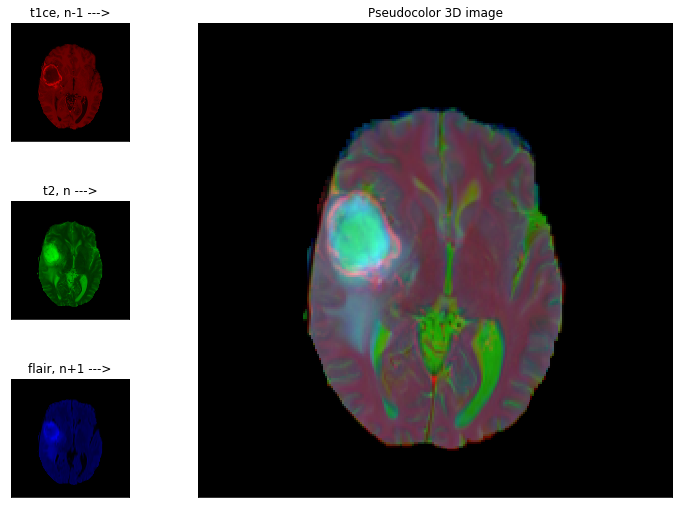

In [14]:
fig = plt.figure(figsize=(12, 12))
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.5)

main_ax=fig.add_subplot(grid[:-1,1:],xticklabels=[],yticklabels=[], xticks=[], yticks=[], title='Pseudocolor 3D image')
red_ax=fig.add_subplot(grid[0,0],xticklabels=[],yticklabels=[], xticks=[], yticks=[], title='t1ce, n-1 --->')
green_ax=fig.add_subplot(grid[1,0],xticklabels=[],yticklabels=[], xticks=[], yticks=[], title='t2, n --->')
blue_ax=fig.add_subplot(grid[2,0],xticklabels=[],yticklabels=[], xticks=[], yticks=[], title='flair, n+1 --->')

main_ax.imshow(a)
red_ax.imshow(red)
green_ax.imshow(green)
blue_ax.imshow(blue)

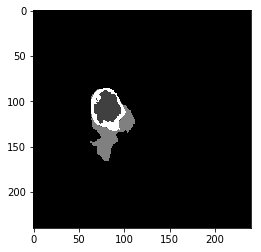

In [15]:
#the same region, but segmented
myshow(seg_arr, 71)

## As we see after combining three modalities to make a preudocolor image, we can observe perfect visualisation of brain tumor and even tumor features.

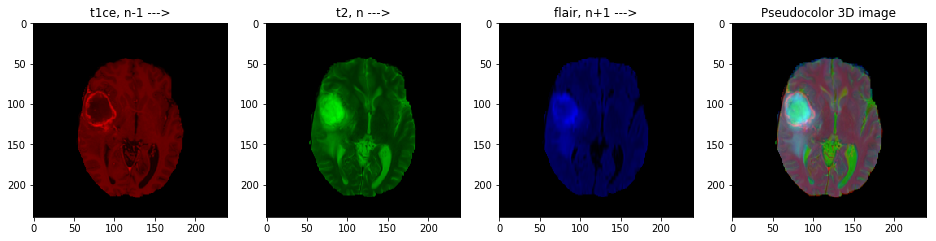

In [16]:
plt.figure(1, figsize=(16,16))

plt.subplot(141, title='t1ce, n-1 --->')
plt.imshow(red)

plt.subplot(142, title='t2, n --->')
plt.imshow(green)

plt.subplot(143, title='flair, n+1 --->')
plt.imshow(blue)

plt.subplot(144, title='Pseudocolor 3D image')
plt.imshow(a)

plt.show()

### We have a number of volume slides empty that is a good idea to check what slides are fully empty and exclude them from the volumes to reduce future computational costs


### Additionally, after that we are going to make new volumes by combining our corresponding slides as shown above and save them to pickle data frame, for each volume it is going to be corresponding ground truth labels for validation of our segmentation.

### To augment our data we can use different combinations of slides positions, also in we can use rotation augmentations, zooming and also we can use different modalities for creating of our images 

### We should create arrays of arrays of volumes in order to recieve trainable data


### After, we should normilize our arrays and we will be ready to start training proceedure 

### Why we decided to use t1ce, t2 and flair. Because <mark><i>t1ce</i></mark> gives the best  visualization of <mark>'enhancing tumor'</mark> subregion, which labeled as 4. Further, t2 is shown <mark>'tumor core'</mark> as a hyperintense region labeled 1. Flair or blue image has shown whole tumor and labeled as 2.  

#### Further, we are going to combine arrays of corresponding modalities into one array, as depicted above
#### First of all as we decided 'red' is going to be t1ce, green - t2 and blue - flair modalities.
#### So, the first step is to transfere these modalities into corresponding color channels











In [32]:
@jit
def get_arrays(data, col=[]):
    for i in col:
        for counter, value in enumerate(data[i]):
            print(counter)
            print(value)
        
get_arrays(data_paths, ['t1ce_p', 'flair_p', 't2_p'])

0
/mnt/e//Image Processing/Brats Project/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_10_1/Brats18_2013_10_1_t1ce.nii.gz
1
/mnt/e//Image Processing/Brats Project/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_11_1/Brats18_2013_11_1_t1ce.nii.gz
2
/mnt/e//Image Processing/Brats Project/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_12_1/Brats18_2013_12_1_t1ce.nii.gz
3
/mnt/e//Image Processing/Brats Project/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_13_1/Brats18_2013_13_1_t1ce.nii.gz
4
/mnt/e//Image Processing/Brats Project/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_14_1/Brats18_2013_14_1_t1ce.nii.gz
5
/mnt/e//Image Processing/Brats Project/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_17_1/Brats18_2013_17_1_t1ce.nii.gz
6
/mnt/e//Image Processing/Brats Project/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_18_1/Brats18_2013_18_1_t1ce.nii.gz
7
/mnt/e//Image Processing/Brats Project/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_19_1/Brats18_2013_19_1_t1ce.nii.gz


In [127]:
#changing colors for modalities 
@jit
def change_color(data, colormap, col):
        
        
    #loop among column name 
    for number, val in enumerate(data[col]):
            
        image=sitk.ReadImage(data.loc[number, col])
        
        new_image=sitk.ScalarToRGBColormap(image,colormap)
        
            
        sitk.WriteImage(new_image, val)  #writes image with new colormap to the same directory 
        
        print('{} DONE!.......'.format(val.split('/')[-1]))
            
            

            
#if we need something specific,m we can use this function            
@jit            
def change_spec(data=data_paths['t1ce_p'][156:], color=r):
    
    for i in data:
        image=sitk.ReadImage(i)
        new_image=sitk.ScalarToRGBColormap(image,color)
        sitk.WriteImage(new_image, i)
        
    
            
            
            
            
            

In [88]:
#Creating filters of rgb colors

r=sitk.ScalarToRGBColormapImageFilter.Red
g=sitk.ScalarToRGBColormapImageFilter.Green
b=sitk.ScalarToRGBColormapImageFilter.Blue


    
change_color(data_paths, r, 't1ce_p')
    
change_color(data_paths, g, 't2_p')
    
change_color(data_paths, b, 'flair_p')
    
    


Brats18_2013_10_1_t2.nii.gz DONE!.......
Brats18_2013_11_1_t2.nii.gz DONE!.......
Brats18_2013_12_1_t2.nii.gz DONE!.......
Brats18_2013_13_1_t2.nii.gz DONE!.......
Brats18_2013_14_1_t2.nii.gz DONE!.......
Brats18_2013_17_1_t2.nii.gz DONE!.......
Brats18_2013_18_1_t2.nii.gz DONE!.......
Brats18_2013_19_1_t2.nii.gz DONE!.......
Brats18_2013_20_1_t2.nii.gz DONE!.......
Brats18_2013_21_1_t2.nii.gz DONE!.......
Brats18_2013_22_1_t2.nii.gz DONE!.......
Brats18_2013_23_1_t2.nii.gz DONE!.......
Brats18_2013_25_1_t2.nii.gz DONE!.......
Brats18_2013_26_1_t2.nii.gz DONE!.......
Brats18_2013_27_1_t2.nii.gz DONE!.......
Brats18_2013_2_1_t2.nii.gz DONE!.......
Brats18_2013_3_1_t2.nii.gz DONE!.......
Brats18_2013_4_1_t2.nii.gz DONE!.......
Brats18_2013_5_1_t2.nii.gz DONE!.......
Brats18_2013_7_1_t2.nii.gz DONE!.......
Brats18_CBICA_AAB_1_t2.nii.gz DONE!.......
Brats18_CBICA_AAG_1_t2.nii.gz DONE!.......
Brats18_CBICA_AAL_1_t2.nii.gz DONE!.......
Brats18_CBICA_AAP_1_t2.nii.gz DONE!.......
Brats18_CBICA

Brats18_TCIA06_211_1_t2.nii.gz DONE!.......
Brats18_TCIA06_247_1_t2.nii.gz DONE!.......
Brats18_TCIA06_332_1_t2.nii.gz DONE!.......
Brats18_TCIA06_372_1_t2.nii.gz DONE!.......
Brats18_TCIA06_409_1_t2.nii.gz DONE!.......
Brats18_TCIA06_603_1_t2.nii.gz DONE!.......
Brats18_TCIA08_105_1_t2.nii.gz DONE!.......
Brats18_TCIA08_113_1_t2.nii.gz DONE!.......
Brats18_TCIA08_162_1_t2.nii.gz DONE!.......
Brats18_TCIA08_167_1_t2.nii.gz DONE!.......
Brats18_TCIA08_205_1_t2.nii.gz DONE!.......
Brats18_TCIA08_218_1_t2.nii.gz DONE!.......
Brats18_TCIA08_234_1_t2.nii.gz DONE!.......
Brats18_TCIA08_242_1_t2.nii.gz DONE!.......
Brats18_TCIA08_278_1_t2.nii.gz DONE!.......
Brats18_TCIA08_280_1_t2.nii.gz DONE!.......
Brats18_TCIA08_319_1_t2.nii.gz DONE!.......
Brats18_TCIA08_406_1_t2.nii.gz DONE!.......
Brats18_TCIA08_436_1_t2.nii.gz DONE!.......
Brats18_TCIA08_469_1_t2.nii.gz DONE!.......
Brats18_2013_0_1_t2.nii.gz DONE!.......
Brats18_2013_15_1_t2.nii.gz DONE!.......
Brats18_2013_16_1_t2.nii.gz DONE!......

KeyError: 'flair'

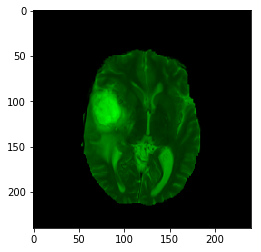

In [187]:
arr=sitk.GetArrayFromImage(sitk.ReadImage(data_paths.loc[0, 't2_p']))

myshow(arr, 71)